In [1]:
import torch
from math import pi,sqrt,log,e,exp
from time import time
from matplotlib import pyplot
import numpy as np
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
#torch.set_default_dtype(torch.float64)
device = torch.device("cuda:4")

from src.models.flows.coupling_cells.real_nvp import RealNVP
from src.models.flows.sampling import FactorizedFlowPrior
from src.models.flows.analytic_flows.element_wise import InvertibleAnalyticSigmoid
from src.models.flows.sequential import InvertibleSequentialFlow

In [2]:
prior_mu =  torch.tensor(0.).to(device)
prior_sig =  torch.tensor(1.2).to(device)
prior = torch.distributions.normal.Normal(prior_mu,prior_sig)

sampler = FactorizedFlowPrior(d=2,prior_1d=prior)

sig = InvertibleAnalyticSigmoid(d=2)

In [3]:
npoints = 100000
points = torch.zeros(npoints,3).to(device).uniform_()
points[:,-1]=0.

In [35]:
fs = f(points)

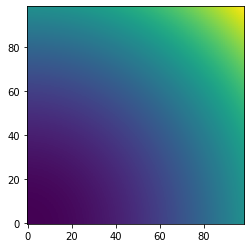

In [37]:
xy = torch.zeros(99,99).to(device)
for i in range(99):
    for j in range(99):
        xy[i,j] = f(torch.tensor(
        [[(i+1)/100.,(j+1)/100.]]
        ))

plt.imshow(xy.cpu().numpy().T,origin="lower")

In [38]:
try:
    del nvps
except:
    pass
nvps = [
        RealNVP(d=2,
              mask=[True,False],
              d_hidden=512,
              n_hidden=8,).to(device),
        RealNVP(d=2,
              mask=[False,True],
              d_hidden=8,
              n_hidden=512,).to(device),
        RealNVP(d=2,
              mask=[True,False],
              d_hidden=512,
              n_hidden=8,).to(device),
        RealNVP(d=2,
              mask=[False,True],
              d_hidden=8,
              n_hidden=512,).to(device),
        sig
]

for n in nvps:
    n.invert()
nvps.reverse()

optim=torch.optim.Adam(sum([list(n.parameters()) for n in nvps],[]),lr=1.e-5)

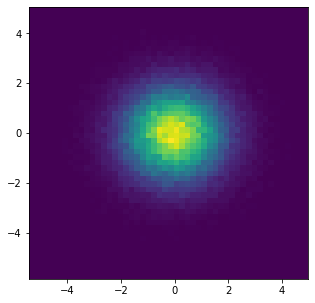

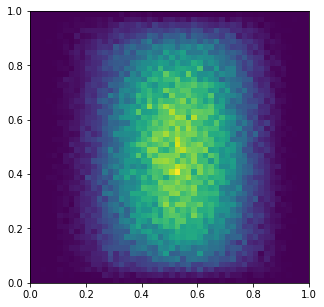

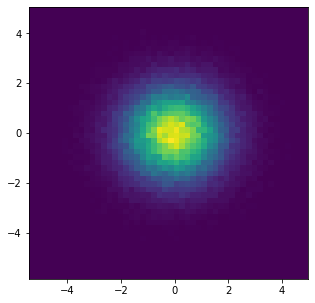

In [41]:
zz = sampler(100000)
xx = zz

plt.figure(figsize=(5,5))
h1=plt.hist2d(xx[:,0].cpu().numpy(),xx[:,1].cpu().numpy(),bins=50)
plt.show()


for n in nvps:
    n.invert()
nvps.reverse()
with torch.no_grad():
    for nvp in nvps:
        xx=nvp(xx)
    xx = xx.cpu().detach().numpy()
    plt.figure(figsize=(5,5))
    plt.hist2d(xx[:,0],xx[:,1],range=((0,1),(0,1)),bins=50)
    plt.show()
for nn in nvps:
    nn.invert()
nvps.reverse()

with torch.no_grad():
    xx=torch.tensor(xx).to(device)
    for nvp in nvps:
        xx=nvp(xx)
plt.figure(figsize=(5,5))
h2=plt.hist2d(xx[:,0].cpu().numpy(),xx[:,1].cpu().numpy(),bins=50)
plt.show()

In [50]:
torch.max(torch.abs(xx-zz)/(1.e-7+ torch.abs(xx)+torch.abs(zz)))

tensor(0.0121, device='cuda:4')

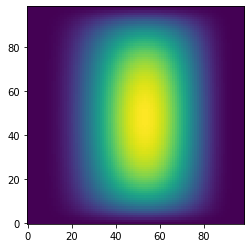

In [51]:
xy = torch.zeros(99,99,3).to(device)
for i in range(99):
    for j in range(99):
        xy[i,j,0] = (i+1)/100.
        xy[i,j,1] = (j+1)/100.
        xy[i,j,2] = 1
        
with torch.no_grad():
    for nn in nvps:
        xy = nn(xy)

p = xy[...,-1] +torch.sum(sampler.prior.log_prob(xy[...,:-1]),axis=-1)
plt.imshow((torch.exp(p)).cpu().numpy().T,origin="lower",interpolation="none")

# Checking the sequential invertible model


In [5]:
model  = InvertibleSequentialFlow(2,[
        RealNVP(d=2,
              mask=[True,False],
              d_hidden=256,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[False,True],
              d_hidden=256,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[True,False],
              d_hidden=256,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[False,True],
              d_hidden=256,
              n_hidden=16,).to(device),
    sig,
])


model.invert()

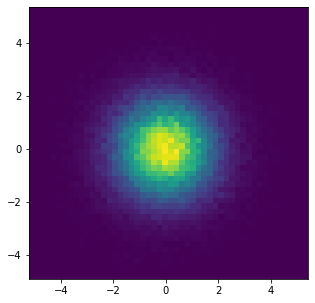

False


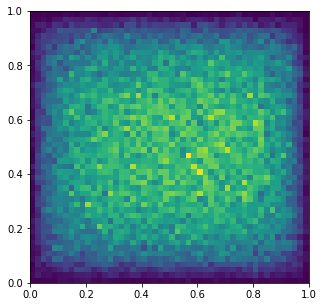

True


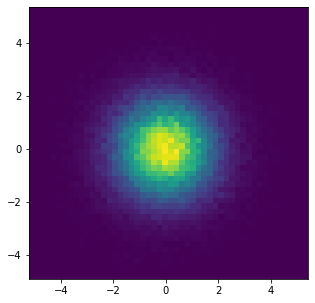

In [6]:
zz = sampler(100000)
xx = zz

plt.figure(figsize=(5,5))
h1=plt.hist2d(xx[:,0].cpu().numpy(),xx[:,1].cpu().numpy(),bins=50)
plt.show()


model.invert()
print(model.inverse)
with torch.no_grad():
    xx = model(xx)
    xx = xx.cpu().detach().numpy()
    plt.figure(figsize=(5,5))
    plt.hist2d(xx[:,0],xx[:,1],range=((0,1),(0,1)),bins=50)
    plt.show()
model.invert()

print(model.inverse)
with torch.no_grad():
    xx=torch.tensor(xx).to(device)
    xx = model(xx)
plt.figure(figsize=(5,5))
h2=plt.hist2d(xx[:,0].cpu().numpy(),xx[:,1].cpu().numpy(),bins=50)
plt.show()

# Training with the sequential invertible model

In [39]:
def f(x):
    return torch.exp(-10*(2*x[:,1]-torch.cos(2*2*3.14159*x[:,0])-1)**2)

In [48]:
model  = InvertibleSequentialFlow(2,[
        RealNVP(d=2,
              mask=[True,False],
              d_hidden=64,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[False,True],
              d_hidden=64,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[True,False],
              d_hidden=64,
              n_hidden=16,).to(device),
        RealNVP(d=2,
              mask=[False,True],
              d_hidden=64,
              n_hidden=16,).to(device),
    sig,
])


model.invert()

optim=torch.optim.Adam(model.parameters(),lr=1.e-4)
Ls = []

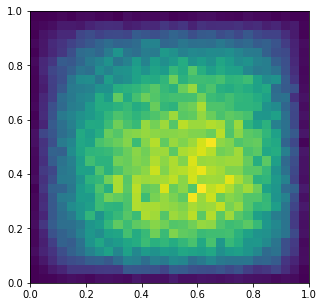

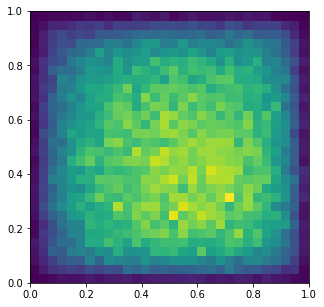

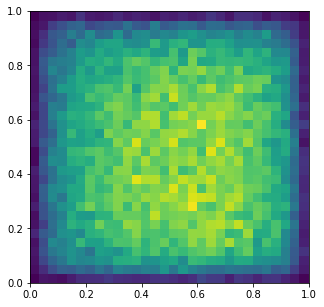

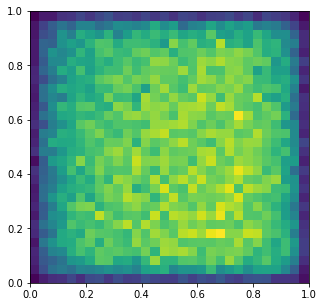

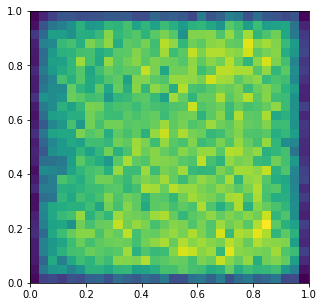

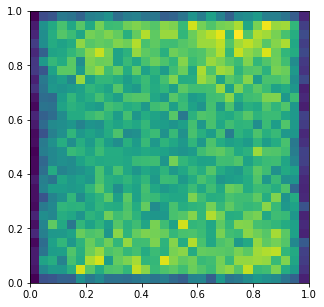

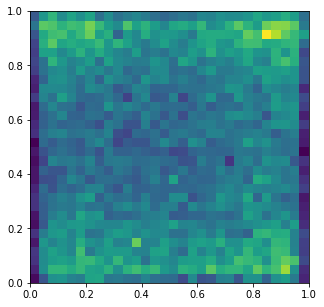

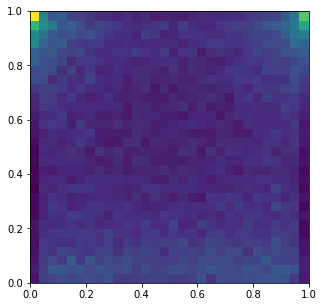

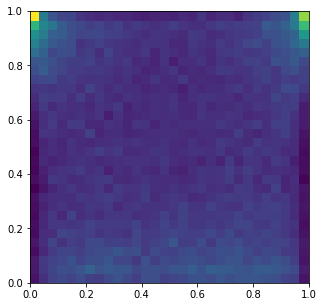

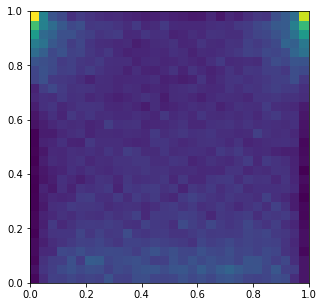

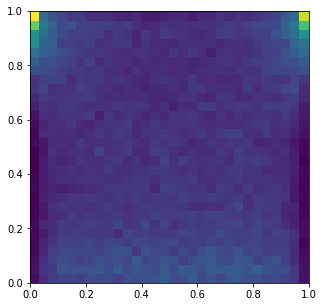

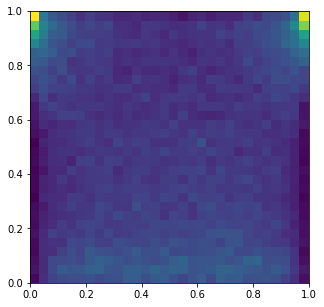

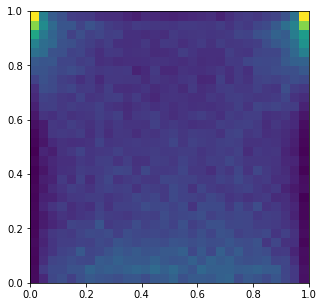

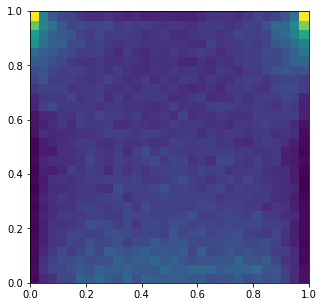

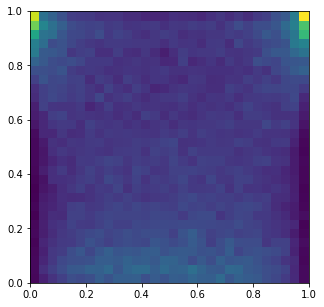

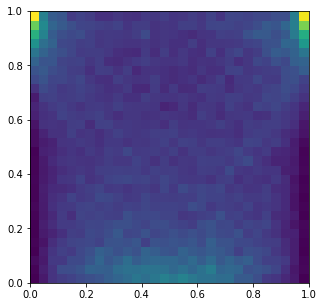

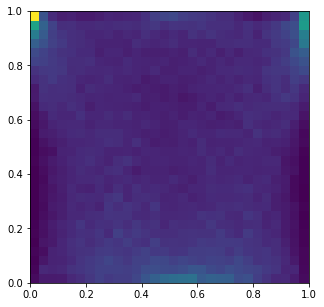

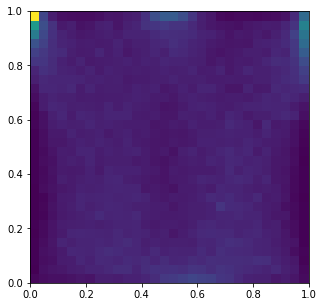

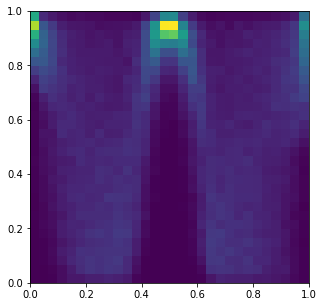

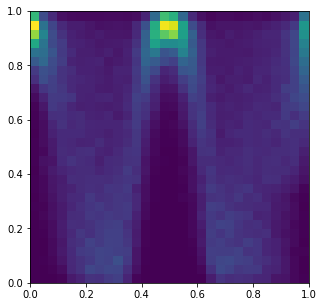

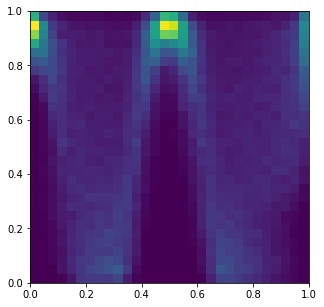

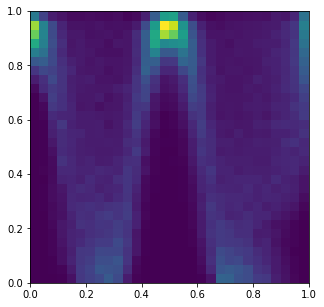

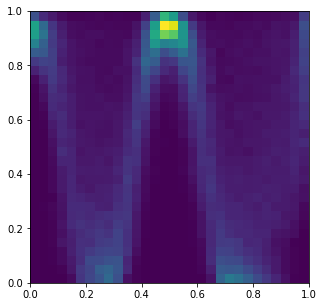

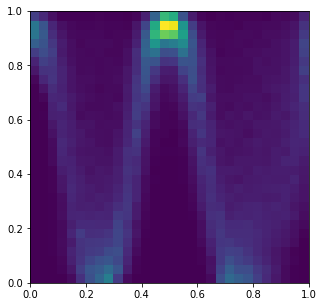

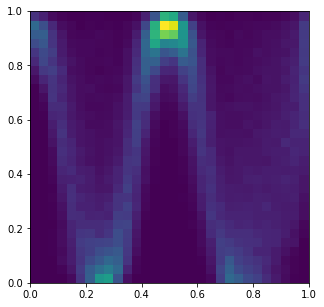

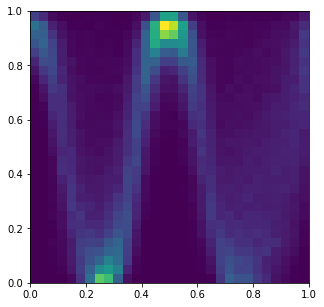

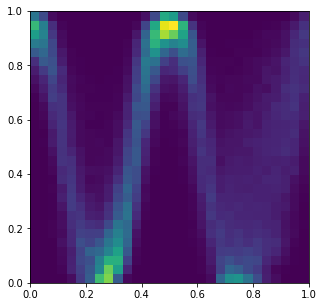

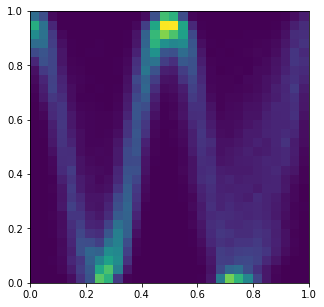

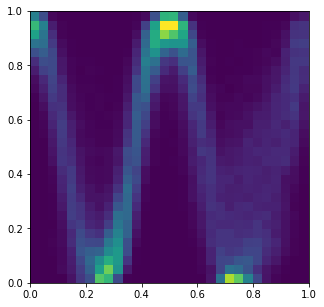

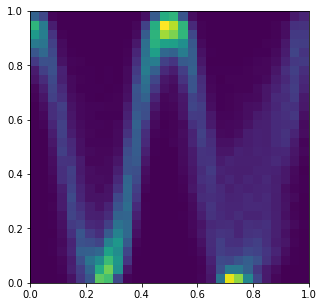

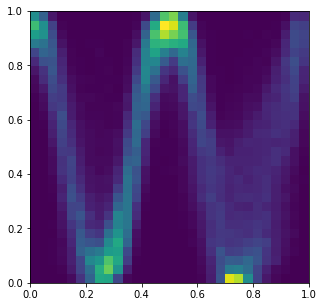

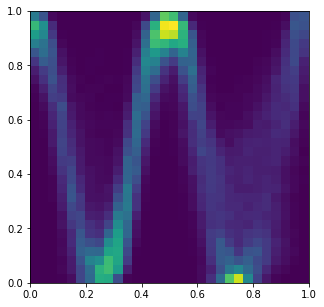

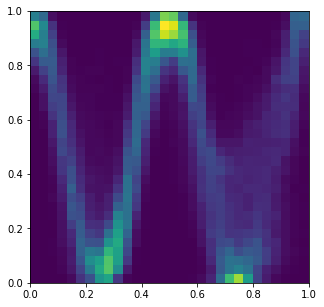

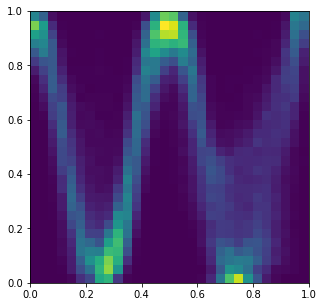

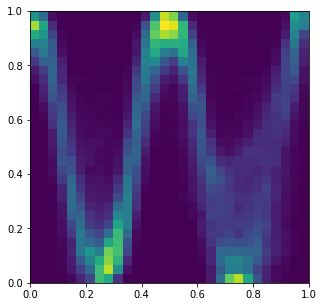

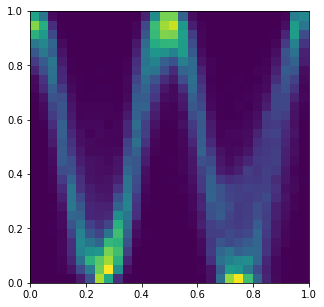

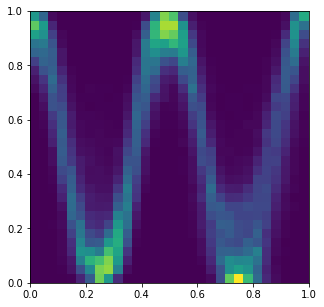

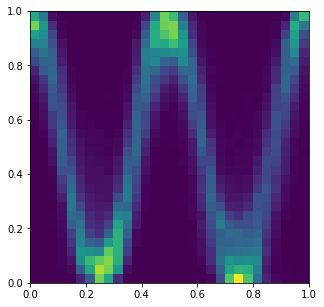

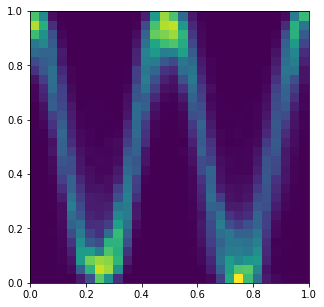

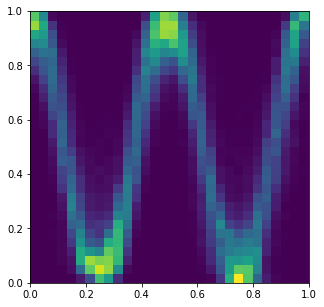

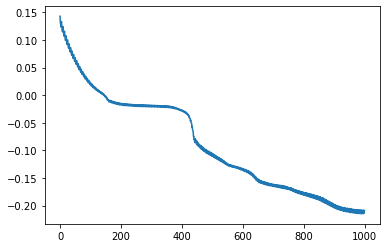

In [49]:
n=5

npoints = 100000

points = torch.zeros(npoints,3).to(device).uniform_()
points[:,-1]=0.
fs = f(points)

for k in range(200):

    if k%5 == 0:
        model.invert()
        with torch.no_grad():
            xx = sampler(100000)
            xx = model(xx).cpu().numpy()
            plt.figure(figsize=(5,5))
            plt.hist2d(xx[:,0],xx[:,1],range=((0,1),(0,1)),bins=30)
            plt.show()
        model.invert()
    
    for i in range(n):
        optim.zero_grad()
        xj = (points[i*(npoints//n):(i+1)*(npoints//n)])
        xj = model(xj)
        x = xj[:,:2]
        j = xj[:,-1]+torch.sum(sampler.prior.log_prob(x),axis=-1)
        L=torch.mean(-j*fs[i*(npoints//n):(i+1)*(npoints//n)])
        L.backward()
        optim.step()
        Ls.append(L.cpu().detach())

plt.plot(Ls)
plt.show()